In [1]:
import numpy as np
import seaborn as sns;
from matplotlib import pyplot as plt
import itertools
import keras

from pycpd import RigidRegistration
from pycpd import AffineRegistration
from pycpd import DeformableRegistration
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_blobs

Using TensorFlow backend.


In [2]:
cd /Users/William/Documents/GitHub/progressive-learning

/Users/William/Documents/GitHub/progressive-learning


In [3]:
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter

from joblib import Parallel, delayed
import time
from itertools import product
import pandas as pd

In [4]:
def split(data_x, data_y, classes=[0,1,2]):
    x = data_x.copy()
    y = data_y.copy()
    i = np.array([np.where(data_y == u)[0] for u in classes]).ravel()
    
    return x[i,:], y[i]



def _generate_2d_rotation(theta=0):
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

    return R



def generate_gaussian_parity(n_samples, centers=None, class_label=None,
    cluster_std=0.25, angle_params=None, random_state=None):

    if random_state != None:
        np.random.seed(random_state)

    if centers == None:
        centers = np.array([(-0.5, 0.5), (0.5, 0.5), (-0.5, -0.5), (0.5, -0.5)])

    if class_label == None:
        class_label = [0, 1, 1, 0]

    blob_num = len(class_label)

    # get the number of samples in each blob with equal probability
    samples_per_blob = np.random.multinomial(
        n_samples, 1 / blob_num * np.ones(blob_num)
    )

    X, y = make_blobs(
        n_samples=samples_per_blob,
        n_features=2,
        centers=centers,
        cluster_std=cluster_std,
    )

    for blob in range(blob_num):
        y[np.where(y == blob)] = class_label[blob]

    if angle_params != None:
        R = _generate_2d_rotation(angle_params)
        X = X @ R

    return X, y

In [5]:
def init_forest(max_depth):
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(2)}
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    return progressive_learner

In [6]:
def cpd_reg(task, task_to_match, max_iter=10):
    template = task;
    target = task_to_match;
    
    registration = AffineRegistration(X=target, Y=template, max_iterations=max_iter)
    deformed_template = registration.register(template)
    
    return deformed_template[0]

In [7]:
def cpd_reg2(temp, temp_class, targ, targ_class, max_iter=200):
    template = np.c_[temp, temp_class];
    target = np.c_[targ, targ_class];
    
    registration = AffineRegistration(X=target, Y=template, max_iterations=max_iter)
    deformed_template = registration.register(temp)
    
    dt = deformed_template[0]
    
    return dt[:,:-1], np.around(dt[:, -1])

# XOR to R_XOR

In [8]:
#Make XOR and R_XOR
X1, y1 = generate_gaussian_parity(n_samples=1000)
X2, y2 = generate_gaussian_parity(n_samples=1000, angle_params=np.pi/2)

In [9]:
#Registration
template = np.c_[X1, y1]
target = np.c_[X2, y2]
temp = X1

df_reg = AffineRegistration(X=target, Y=template, max_iterations=50)
deformed_template = df_reg.register(temp)

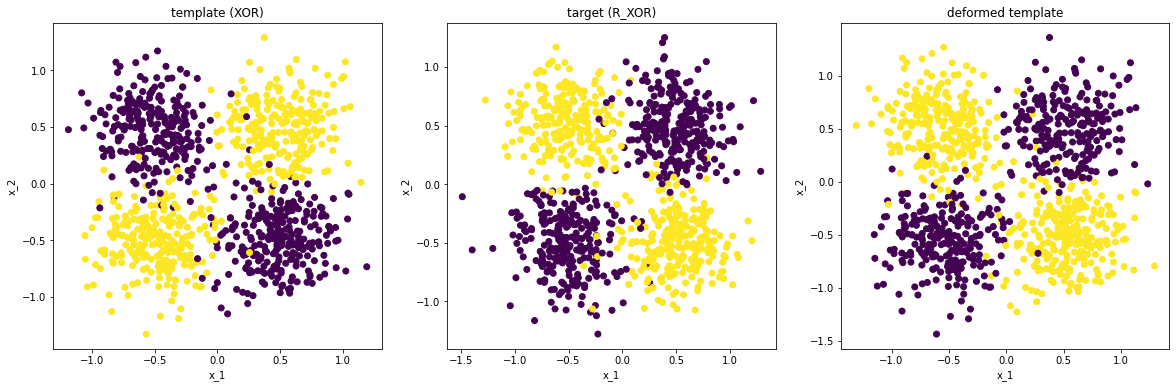

In [10]:
#plot
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.scatter(X1[:,0], X1[:,1], c=y1)
plt.title("template (XOR)")
plt.xlabel("x_1"); plt.ylabel("x_2");

plt.subplot(132)
plt.scatter(X2[:,0], X2[:,1], c=y2)
plt.title("target (R_XOR)")
plt.xlabel("x_1"); plt.ylabel("x_2");

z = deformed_template[0]
plt.subplot(133)
plt.scatter(z[:,0], z[:,1], c=z[:,2]);
plt.title("deformed template")
plt.xlabel("x_1"); plt.ylabel("x_2");

# XOR to translated R_XOR

In [11]:
#Make XOR and R_XOR
X1, y1 = generate_gaussian_parity(n_samples=1000)
X2, y2 = generate_gaussian_parity(n_samples=1000, angle_params=np.pi/3)
X2 = X2 + 5

In [12]:
#Registration
template = X1
target = X2
temp = X1

af_reg = AffineRegistration(X=target, Y=template, max_iterations=10)
deformed_template_af = af_reg.register(temp)

In [ ]:
#plot
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.scatter(X1[:,0], X1[:,1], c=y1)
plt.title("template (XOR)")

plt.subplot(132)
plt.scatter(X2[:,0], X2[:,1], c=y2)
plt.title("target (R_XOR)")

z_af = deformed_template_af[0]
plt.subplot(133)
plt.scatter(z_af[:,0], z_af[:,1], c=y1)
plt.title("deformed template")

In [ ]:
#parameters
n_task1=100; n_task2=100; n_test=1000; task1_angle=0; task2_angle=np.pi/5; n_trees=10

#source data
X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)

#target data
X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task2_angle)
X_task2 = X_task2 + 5
test_task2 = test_task2 + 5

#registered data
X_task1b = cpd_reg(X_task2, X_task1)
X_task2b = cpd_reg(X_task1, X_task2)

In [ ]:
def experiment1(n):

    #parameters
    n_task1=n; n_task2=n; n_test=1000; task1_angle=0; task2_angle=np.pi/3; n_trees=10

    #source data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)

    #target data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
    X_task2 = X_task2 + 5

    #registered data
    X_task1b = cpd_reg(X_task2, X_task1)
    
    # train on task1 & predict on task 1 test
    progressive_learner = init_forest(max_depth=np.ceil(np.log2(n_task1)))
    progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)
    progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)

    train1pred1 = progressive_learner.predict(test_task1, task_id=0)

    a = 1 - np.mean(train1pred1 == test_label_task1)

    # train on task1, task1b & predict on task 1
    progressive_learner = init_forest(max_depth=np.ceil(np.log2(n_task1)))
    progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)
    progressive_learner.add_task(X_task1b, y_task1, num_transformers=n_trees)

    train1bpred1 = progressive_learner.predict(test_task1, task_id=0)

    b = 1 - np.mean(train1bpred1 == test_label_task1)
    
    return [a,b]

In [ ]:
n_samples = [100, 250, 500, 750, 1000]
errors = {};

for i in n_samples:
    e = [];
    
    for j in range(50):
        e.append(experiment1(i))
        
    errors[i] = e;

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(20,5), sharex=True, sharey=True)


for i in range(2):
    e = np.array([errors[n] for n in n_samples]).T
    df = pd.DataFrame(e[i])
    df = df.melt(value_vars=df.columns)
    ax = axs[i]
    sns.stripplot(data=df, x='variable', y='value', ax=ax)
    plt.ylim([0,0.15])
    
    if i == 0:
        ax.set_title('Train on task1 data only')
    else:
        ax.set_title('Train on task1 and deformed task2 data')
    
    ax.set_ylabel('Generalization Error')
    ax.set_xticklabels(n_samples)
    ax.set_xlabel('# training samples')

# XOR to translated R_XOR with labeles determined by EM

In [16]:
#Make XOR and R_XOR
X1, y1 = generate_gaussian_parity(n_samples=1000)
X2, y2 = generate_gaussian_parity(n_samples=1000, angle_params=np.pi/3)
X2 = X2 + 5

In [18]:
#Registration
#template = np.c_[X1, y1]
#target = np.c_[X2, y2]
#temp = X1

#af_reg = AffineRegistration(X=target, Y=template, max_iterations=200)
#deformed_template_af = af_reg.register(temp)

X_af, y_af = cpd_reg2(X1, y1, X2, y2)

Text(0.5, 1.0, 'input the algorithm sees')

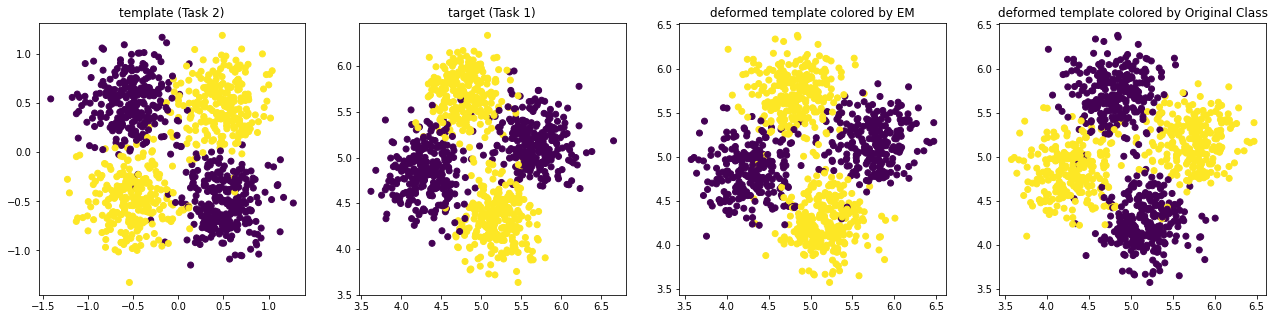

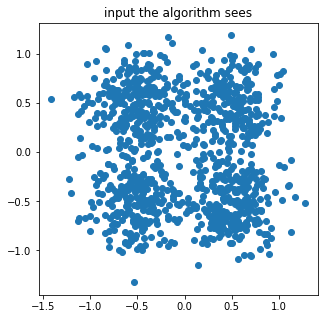

In [19]:
#plot
plt.figure(figsize=(22,5))
plt.subplot(141)
plt.scatter(X1[:,0], X1[:,1], c=y1)
plt.title("template (Task 2)")

plt.subplot(142)
plt.scatter(X2[:,0], X2[:,1], c=y2)
plt.title("target (Task 1)")

plt.subplot(143)
plt.scatter(X_af[:,0], X_af[:,1], c=y_af)
plt.title("deformed template colored by EM")

plt.subplot(144)
plt.scatter(X_af[:,0], X_af[:,1], c=y1)
plt.title("deformed template colored by Original Class")

#plot
plt.figure(figsize=(5,5))
plt.scatter(X1[:,0], X1[:,1])
plt.title("input the algorithm sees")

In [20]:
def experiment2(n):

    #parameters
    n_task1=n; n_task2=n; n_test=1000; task1_angle=np.pi/(2.5); task2_angle=0; n_trees=10

    #source data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)

    #target data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
    X_task2 = X_task2 + 5

    #registered data
    X_task1b, y_task1b = cpd_reg2(X_task2, y_task2, X_task1, y_task1)
    
    # train on task1 & predict on task 1 test
    progressive_learner = init_forest(max_depth=np.ceil(np.log2(n_task1)))
    progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)
    progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)

    train1pred1 = progressive_learner.predict(test_task1, task_id=0)

    a = 1 - np.mean(train1pred1 == test_label_task1)

    # train on task1, task1b & predict on task 1
    progressive_learner = init_forest(max_depth=np.ceil(np.log2(n_task1)))
    progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)
    progressive_learner.add_task(X_task1b, y_task1b, num_transformers=n_trees)

    train1bpred1 = progressive_learner.predict(test_task1, task_id=0)

    b = 1 - np.mean(train1bpred1 == test_label_task1)
    
    return [a,b]

In [21]:
n_samples = [100, 250, 500, 750]
errors = {};

for i in n_samples:
    e = [];
    
    for j in range(50):
        e.append(experiment2(i))
        
    errors[i] = e;

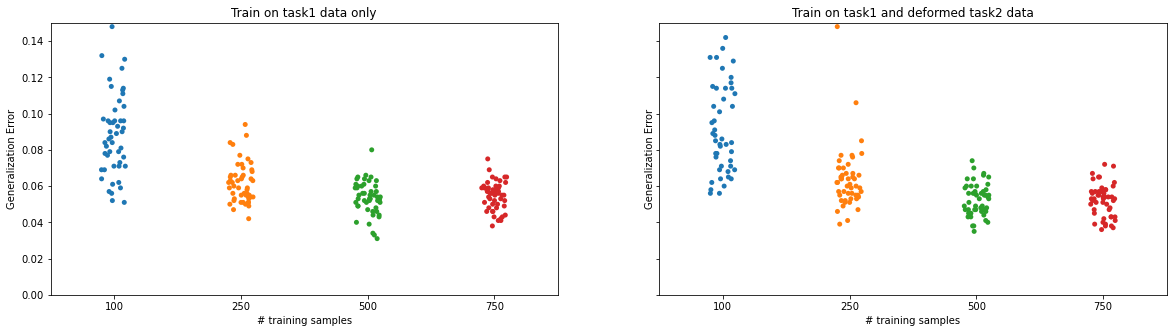

In [22]:
fig, axs = plt.subplots(1,2, figsize=(20,5), sharex=True, sharey=True)


for i in range(2):
    e = np.array([errors[n] for n in n_samples]).T
    df = pd.DataFrame(e[i])
    df = df.melt(value_vars=df.columns)
    ax = axs[i]
    sns.stripplot(data=df, x='variable', y='value', ax=ax)
    plt.ylim([0,0.15])
    
    if i == 0:
        ax.set_title('Train on task1 data only')
    else:
        ax.set_title('Train on task1 and deformed task2 data')
    
    ax.set_ylabel('Generalization Error')
    ax.set_xticklabels(n_samples)
    ax.set_xlabel('# training samples')

In [42]:
e = np.array(errors[750])
a = e[:,0]
b = e[:,1]

print("Task 1 only mean, median: ", np.mean(a), np.median(a))
print("Task 1 and 1b mean , median: ", np.mean(b), np.median(b))

Task 1 only mean, median:  0.05466000000000003 0.05600000000000005
Task 1 and 1b mean , median:  0.05218000000000003 0.05300000000000005


# XOR to translated R-XOR via clustering

In [23]:
from sklearn.cluster import KMeans

In [24]:
#Make XOR and R_XOR
X1, y1 = generate_gaussian_parity(n_samples=1000)
X2, y2 = generate_gaussian_parity(n_samples=1000, angle_params=np.pi/3)
X2 = X2 + 5

In [25]:
KM1 = KMeans(n_clusters=4, n_init=100,init='k-means++')
KM2 = KMeans(n_clusters=4, n_init=100,init='k-means++')
KM1.fit(X1)
KM2.fit(X2)
C1 = KM1.cluster_centers_ 
C2 = KM2.cluster_centers_ 

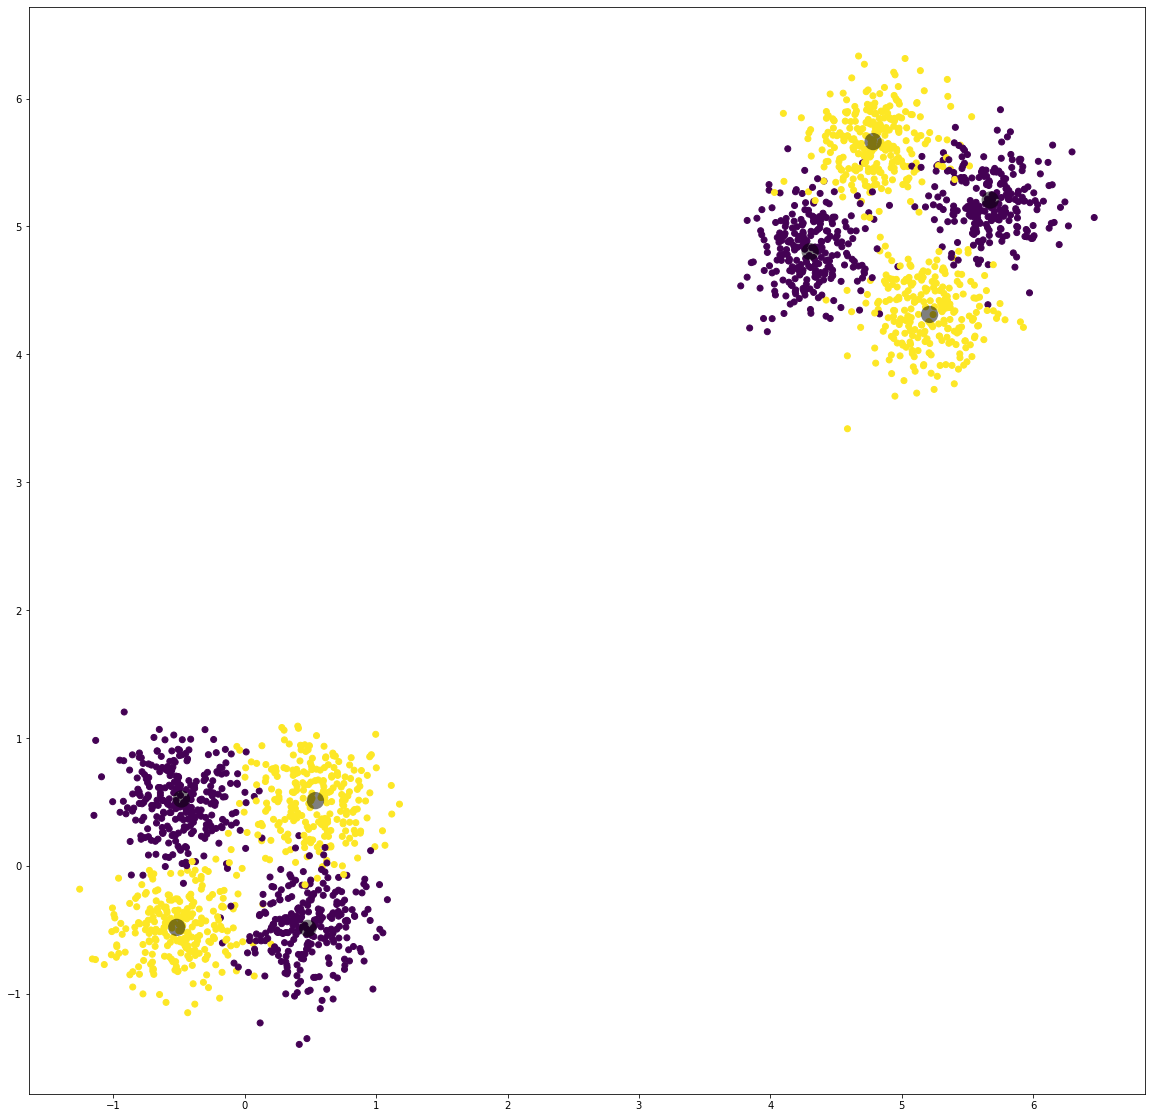

In [26]:
plt.figure(figsize=(20,20))
plt.scatter(X1[:,0], X1[:,1], c=y1)
plt.scatter(X2[:,0], X2[:,1], c=y2)
plt.scatter(C1[:,0],C1[:,1],c='k',marker='o',s=300,alpha=0.5,edgecolor='none');
plt.scatter(C2[:,0],C2[:,1],c='k',marker='o',s=300,alpha=0.5,edgecolor='none');

In [28]:
template = C1
target = C2
temp = X1

af_reg = AffineRegistration(X=target, Y=template, max_iterations=1000)
B, t = af_reg.get_registration_parameters()

#deformed_template_af = af_reg.register(temp)
deformed_template_af = np.dot(X1, B) + np.tile(t, (X1.shape[0], 1))

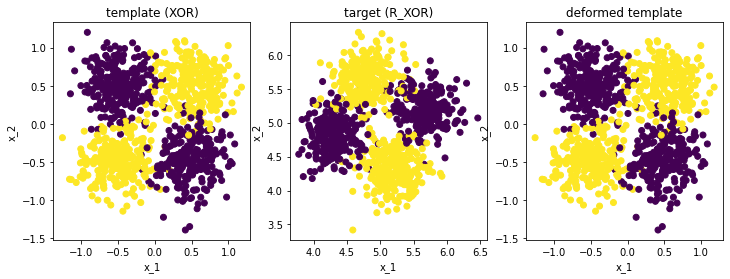

In [29]:
#plot
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.scatter(X1[:,0], X1[:,1], c=y1)
plt.title("template (XOR)")
plt.xlabel("x_1"); plt.ylabel("x_2");

plt.subplot(132)
plt.scatter(X2[:,0], X2[:,1], c=y2)
plt.title("target (R_XOR)")
plt.xlabel("x_1"); plt.ylabel("x_2");

z_af = deformed_template_af
plt.subplot(133)
plt.scatter(z_af[:,0], z_af[:,1], c=y1)
plt.title("deformed template")
plt.xlabel("x_1"); plt.ylabel("x_2");

# Cross-XOR to Cross-R-XOR

In [30]:
def make_XOR(n_samples=100, cluster_center=[0,0], cluster_std=0.25, dist_from_center=0.5,
             angle_params=0, random_state=None):

    seed = random_state
    dist = dist_from_center
    std = cluster_std
    n = int(n_samples/4)
    
    cluster_centers = np.array(list(itertools.product([dist, -dist], repeat=2)))
    cluster_centers = cluster_center - cluster_centers
    n_per_cluster = np.full(shape=2, fill_value=n)

    X1,_ = make_blobs(n_samples=n_per_cluster, n_features=2, centers=cluster_centers[[0,3], :], 
                               cluster_std=std, random_state=seed)
    X2,_ = make_blobs(n_samples=n_per_cluster, n_features=2, centers=cluster_centers[[1,2], :], 
                               cluster_std=std, random_state=seed)
    
    y1, y2 = np.ones(n*2), np.zeros(n*2)
    
    X = np.concatenate((X1, X2))
    y = np.concatenate((y1, y2))

    c, s = np.cos(angle_params), np.sin(angle_params)
    R = np.array([[c, -s], [s, c]])
    X = (R @ X.T).T
    
    return X,y

In [31]:
#broken
def make_CXOR(n_samples=100, cluster_center=[0,0], cov=[[1, 0], [0, 1]], dist_from_center=0.5,
             angle_params=0, random_state=None):

    seed = random_state
    dist = dist_from_center
    n = int(n_samples/4)
    
    cluster_centers = np.array(list(itertools.product([dist, -dist], repeat=2)))
    cluster_centers = cluster_center - cluster_centers
    n_per_cluster = np.full(shape=2, fill_value=n)
    
    m1=cluster_centers[0, :]
    m2=cluster_centers[1, :]
    m3=cluster_centers[2, :]
    m4=cluster_centers[3, :]
    
    X1 = np.random.multivariate_normal(m1, cov, n_per_cluster)
    X2 = np.random.multivariate_normal(m2, cov, n_per_cluster)
    X3 = np.random.multivariate_normal(m3, cov, n_per_cluster)
    X4 = np.random.multivariate_normal(m4, cov, n_per_cluster)
    
    R2 = np.array([[0, -1], [1, 0]])
    R3 = np.array([[-1, 0], [0, -1]])
    R4 = np.array([[0, 1], [-1, 0]])
    
    X2 = (R2 @ X2.T).T
    X3 = (R3 @ X3.T).T
    X4 = (R4 @ X4.T).T
    
    y1, y2 = np.ones(n*2), np.zeros(n*2)
    
    X = np.concatenate((X1, X2, X3, X4))
    y = np.concatenate((y1, y2))

    c, s = np.cos(angle_params), np.sin(angle_params)
    R = np.array([[c, -s], [s, c]])
    X = (R @ X.T).T
    
    return X,y

In [63]:
#Make XOR and R_XOR
X1, y1 = make_XOR(n_samples=1000, dist_from_center=10, cluster_std=1)
X2, y2 = make_XOR(n_samples=1000, dist_from_center=10, cluster_std=1, angle_params=np.pi/4)
X2 = X2 + 5

In [64]:
#Registration
template = X1
target = X2
temp = X1

af_reg = AffineRegistration(X=target, Y=template, max_iterations=1000)
deformed_template_af = af_reg.register(temp)

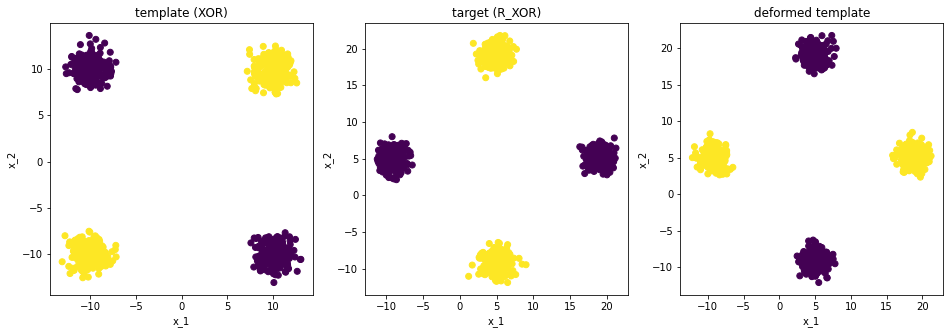

In [65]:
#plot
plt.figure(figsize=(16,5))
plt.subplot(131)
plt.scatter(X1[:,0], X1[:,1], c=y1)
plt.title("template (XOR)")
plt.xlabel("x_1"); plt.ylabel("x_2");

plt.subplot(132)
plt.scatter(X2[:,0], X2[:,1], c=y2)
plt.title("target (R_XOR)")
plt.xlabel("x_1"); plt.ylabel("x_2");

z_af = deformed_template_af[0]
plt.subplot(133)
plt.scatter(z_af[:,0], z_af[:,1], c=y1)
plt.title("deformed template")
plt.xlabel("x_1"); plt.ylabel("x_2");

# CIFAR

In [ ]:
#data setup
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

data_x = np.concatenate([X_train, X_test])
data_x = data_x[:,:,:,0]
data_x = data_x.reshape((data_x.shape[0], data_x.shape[1] * data_x.shape[2]))
#data_x = data_x.reshape((data_x.shape[0], data_x.shape[1] * data_x.shape[2] * data_x.shape[3]))
data_y = np.concatenate([y_train, y_test])
data_y = data_y[:, 0]

X_task1, y_task1 = split(data_x, data_y, classes=[0,1])
X_task2, y_task2 = split(data_x, data_y, classes=[2,3])

#random sample
np.random.seed(10)
sample1 = np.random.uniform(size = len(x_task1)) < 0.01
sample2 = np.random.uniform(size = len(x_task2)) < 0.01
x_task1 = X_task1[sample1]
y_task1 = y_task1[sample1]
X_task2 = X_task2[sample2]
y_task2 = y_task2[sample2]

In [ ]:
#random look at data
a, b = np.random.randint(0,1024, 2)

plt.figure(figsize=(12,6));
plt.subplot(121)
plt.scatter(X_task1[:,a], X_task1[:,b], c=y_task1, alpha=0.6)
plt.title('Task 1')
plt.subplot(122)
plt.scatter(X_task2[:,a], X_task2[:,b], c=y_task2, alpha=0.6)
plt.title('Task 2')